In [3]:
!pip install -e /dss/dsshome1/04/di93zer/git/cellnet --no-deps

Obtaining file:///dss/dsshome1/04/di93zer/git/cellnet
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cellnet

[notice] A new release of pip is available: 23.1.1 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
from os.path import join
from typing import List

import anndata
import scanpy as sc
import dask.dataframe as dd
import dask.array as da
import pandas as pd
import numpy as np

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_count_matrix_and_obs(ddf, columns: List[str] = None):
    if not columns:
        columns = ['cell_type', 'tech_sample', 'assay', 'dataset_id', 'tissue_general', 'disease']
    x = (
        ddf['X']
        .map_partitions(
            lambda xx: pd.DataFrame(np.vstack(xx.tolist())), 
            meta={col: 'f4' for col in range(19331)}
        )
        .to_dask_array(lengths=[1024] * ddf.npartitions)
    )
    obs = ddf[columns].compute()
    
    return x, obs


# Check data loader performance

In [3]:
import cupy
import numpy as np
import pandas as pd
import cudf

from os.path import join

In [4]:
PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p'

In [5]:
import merlin.io
from merlin.dataloader.torch import Loader
from merlin.schema import ColumnSchema, Schema
import pyarrow as pa
import numpy as np


train_dataset = merlin.io.Dataset(
    join(PATH, 'train'), 
    engine='parquet', 
    part_size='100MB',
    schema=Schema([
        ColumnSchema(
            'X', dtype='float32', 
            is_list=True, is_ragged=False, 
            properties={'value_count': {'max': 19331}}
        ),
        ColumnSchema('cell_type', dtype='int64')
    ])
)
val_dataset = merlin.io.Dataset(
    join(PATH, 'val'), 
    engine='parquet', 
    part_size='325MB',
    schema=Schema([
        ColumnSchema(
            'X', dtype='float32', 
            is_list=True, is_ragged=False, 
            properties={'value_count': {'max': 19331}}
        ),
        ColumnSchema('cell_type', dtype='int64')
    ])
)


/usr/local/lib/python3.8/dist-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")


In [6]:
def benchmark(dataset, batch_size=2048, shuffle=True, parts_per_chunk=1, n_samples=1_000_000):
    import time
    import gc

    num_iter = n_samples // batch_size
    loader = Loader(
        dataset, 
        batch_size=batch_size, 
        shuffle=shuffle,
        parts_per_chunk=parts_per_chunk,
        drop_last=True,
    ).epochs(100)

    # exclude first batch from benchmark as this includes the setup time
    batch = next(loader)
    start_time = time.time()
    for i, (batch, _) in enumerate(loader):
        x, cell_type = batch['X'], batch['cell_type']
        if i == num_iter:
            break
        if i % 10 == 0:
            gc.collect()

    execution_time = time.time() - start_time
    loader.stop()
    print(f'Benchmark results: batch_size={batch_size} - shuffle={shuffle}\n')
    time_per_sample = (1e6 * execution_time) / (num_iter * batch_size)
    print(f'time per sample: {time_per_sample:.2f} μs')
    samples_per_sec = num_iter * batch_size / execution_time
    print(f'samples per sec: {samples_per_sec:.2f} samples/sec')
    gc.collect()

    return samples_per_sec, time_per_sample



In [7]:
res_train = benchmark(train_dataset, batch_size=2048, parts_per_chunk=8, n_samples=1_000_000)

Benchmark results: batch_size=2048 - shuffle=True

time per sample: 110.70 μs
samples per sec: 9033.66 samples/sec


In [8]:
res_val = benchmark(val_dataset, batch_size=2048, shuffle=False, n_samples=1_000_000)

Benchmark results: batch_size=2048 - shuffle=False

time per sample: 38.75 μs
samples per sec: 25803.29 samples/sec


## Compare to in-memory data loading

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
from cellnet.utils.data_loading import dataloader_factory


def benchmark_in_memory(x, obs, batch_size=2048, shuffle=True, n_samples=500_000):
    import time
    import gc

    num_iter = n_samples // batch_size
    loader = dataloader_factory(x, obs, batch_size=batch_size, shuffle=shuffle)

    start_time = time.time()
    for i, (batch, _) in enumerate(loader):
        x, cell_type = batch['X'].to(device='cuda'), batch['cell_type'].to(device='cuda')
        if i == num_iter:
            break
        if i % 10 == 0:
            gc.collect()

    execution_time = time.time() - start_time
    print(f'Benchmark results: batch_size={batch_size} - shuffle={shuffle}\n')
    time_per_sample = (1e6 * execution_time) / (num_iter * batch_size)
    print(f'time per sample: {time_per_sample:.2f} μs')
    samples_per_sec = num_iter * batch_size / execution_time
    print(f'samples per sec: {samples_per_sec:.2f} samples/sec')

    return samples_per_sec, time_per_sample

In [11]:
from scipy.sparse import csr_matrix


ddf_val = dd.read_parquet(join(PATH, 'val'), split_row_groups=True)
x, obs = get_count_matrix_and_obs(ddf_val, columns=['cell_type'])

In [12]:
n_cells = 1_000_000

x = x[:n_cells, :].map_blocks(csr_matrix).compute()
obs = obs[:n_cells]

In [13]:
obs['cell_type'] = obs['cell_type'].astype('category')

In [21]:
res_train_in_mem = benchmark_in_memory(x, obs, batch_size=2048, shuffle=True)

Benchmark results: batch_size=2048 - shuffle=True

time per sample: 35.11 μs
samples per sec: 28478.00 samples/sec


In [22]:
res_val_in_mem = benchmark_in_memory(x, obs, batch_size=2048, shuffle=False)

Benchmark results: batch_size=2048 - shuffle=False

time per sample: 34.70 μs
samples per sec: 28819.96 samples/sec


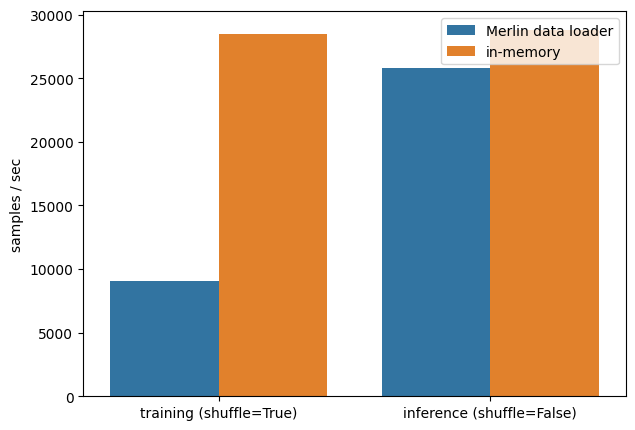

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

sns.barplot(
    pd.DataFrame({
        'samples / sec': [res_train[0], res_val[0], res_train_in_mem[0], res_val_in_mem[0]],
        'training': ['training (shuffle=True)', 'inference (shuffle=False)'] * 2,
        'loader': ['Merlin data loader', 'Merlin data loader', 'in-memory', 'in-memory']
    }),
    x='training',
    y='samples / sec',
    hue='loader'
)
ax.legend(title='')
ax.set_xlabel('')

plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/data-loading-benchmark.pdf')
plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/data-loading-benchmark.png', dpi=300)

# Summary

In [ ]:
!pip install -e /dss/dsshome1/04/di93zer/git/cellnet --no-deps

In [ ]:
!pip install -q SPARQLWrapper

In [11]:
PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p'

In [6]:
ddf_train = dd.read_parquet(join(PATH, 'train'), split_row_groups=True)
ddf_val = dd.read_parquet(join(PATH, 'val'), split_row_groups=True)
ddf_test = dd.read_parquet(join(PATH, 'test'), split_row_groups=True)

cell_type_mapping = pd.read_parquet(join(PATH, 'categorical_lookup/cell_type.parquet'))
tissue_general_mapping = pd.read_parquet(join(PATH, 'categorical_lookup/tissue_general.parquet'))
tissue_mapping = pd.read_parquet(join(PATH, 'categorical_lookup/tissue.parquet'))
disease_mapping = pd.read_parquet(join(PATH, 'categorical_lookup/disease.parquet'))
assay_mapping = pd.read_parquet(join(PATH, 'categorical_lookup/assay.parquet'))

## Sanity check data

In [20]:
import anndata
import scanpy as sc
import numpy as np

In [21]:
from cellnet.utils.cell_ontology import retrieve_child_nodes_from_ubergraph

In [5]:
x_train, obs_train = get_count_matrix_and_obs(ddf_train)
x_val, obs_val = get_count_matrix_and_obs(ddf_val)

In [6]:
from dask_ml.decomposition import IncrementalPCA


n_samples = 200_000

x = da.concatenate([x_train[:n_samples], x_val[:n_samples]])
obs = pd.concat([
    obs_train.iloc[:n_samples].assign(split='train'), 
    obs_val.iloc[:n_samples].assign(split='val')
])

pca = IncrementalPCA(n_components=50, iterated_power=3)
x_pca = da.compute(pca.fit_transform(x))[0]

/usr/local/lib/python3.8/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


In [18]:
adata = anndata.AnnData(X=x_pca, obs=obs)
sc.pp.subsample(adata, n_obs=200_000)
sc.tl.tsne(adata, use_rep='X')

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [19]:
adata.obs['cell_type'] = cell_type_mapping.iloc[adata.obs.cell_type].to_numpy()
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
adata.obs['tissue_general'] = tissue_general_mapping.iloc[adata.obs.tissue_general].to_numpy()
adata.obs['tissue_general'] = adata.obs['tissue_general'].astype('category')
adata.obs['disease'] = disease_mapping.iloc[adata.obs.disease].to_numpy()
adata.obs['disease'] = adata.obs['disease'].astype('category')
adata.obs['assay'] = assay_mapping.iloc[adata.obs.assay].to_numpy()
adata.obs['assay'] = adata.obs['assay'].astype('category')

In [22]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5, 5)

In [23]:
coarse_cell_types = [
    'neural cell', 
    'epithelial cell', 
    'endothelial cell', 
    'B cell', 
    'fibroblast',
    'macrophage', 
    'monocyte', 
    'T cell',
    'natural killer cell',
    'kidney cell',
]
subtypes = retrieve_child_nodes_from_ubergraph(coarse_cell_types)

adata.obs['coarse_cell_type'] = np.nan
for cell_type in coarse_cell_types:
    adata.obs.loc[adata.obs.cell_type.isin(subtypes[cell_type]), 'coarse_cell_type'] = cell_type

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


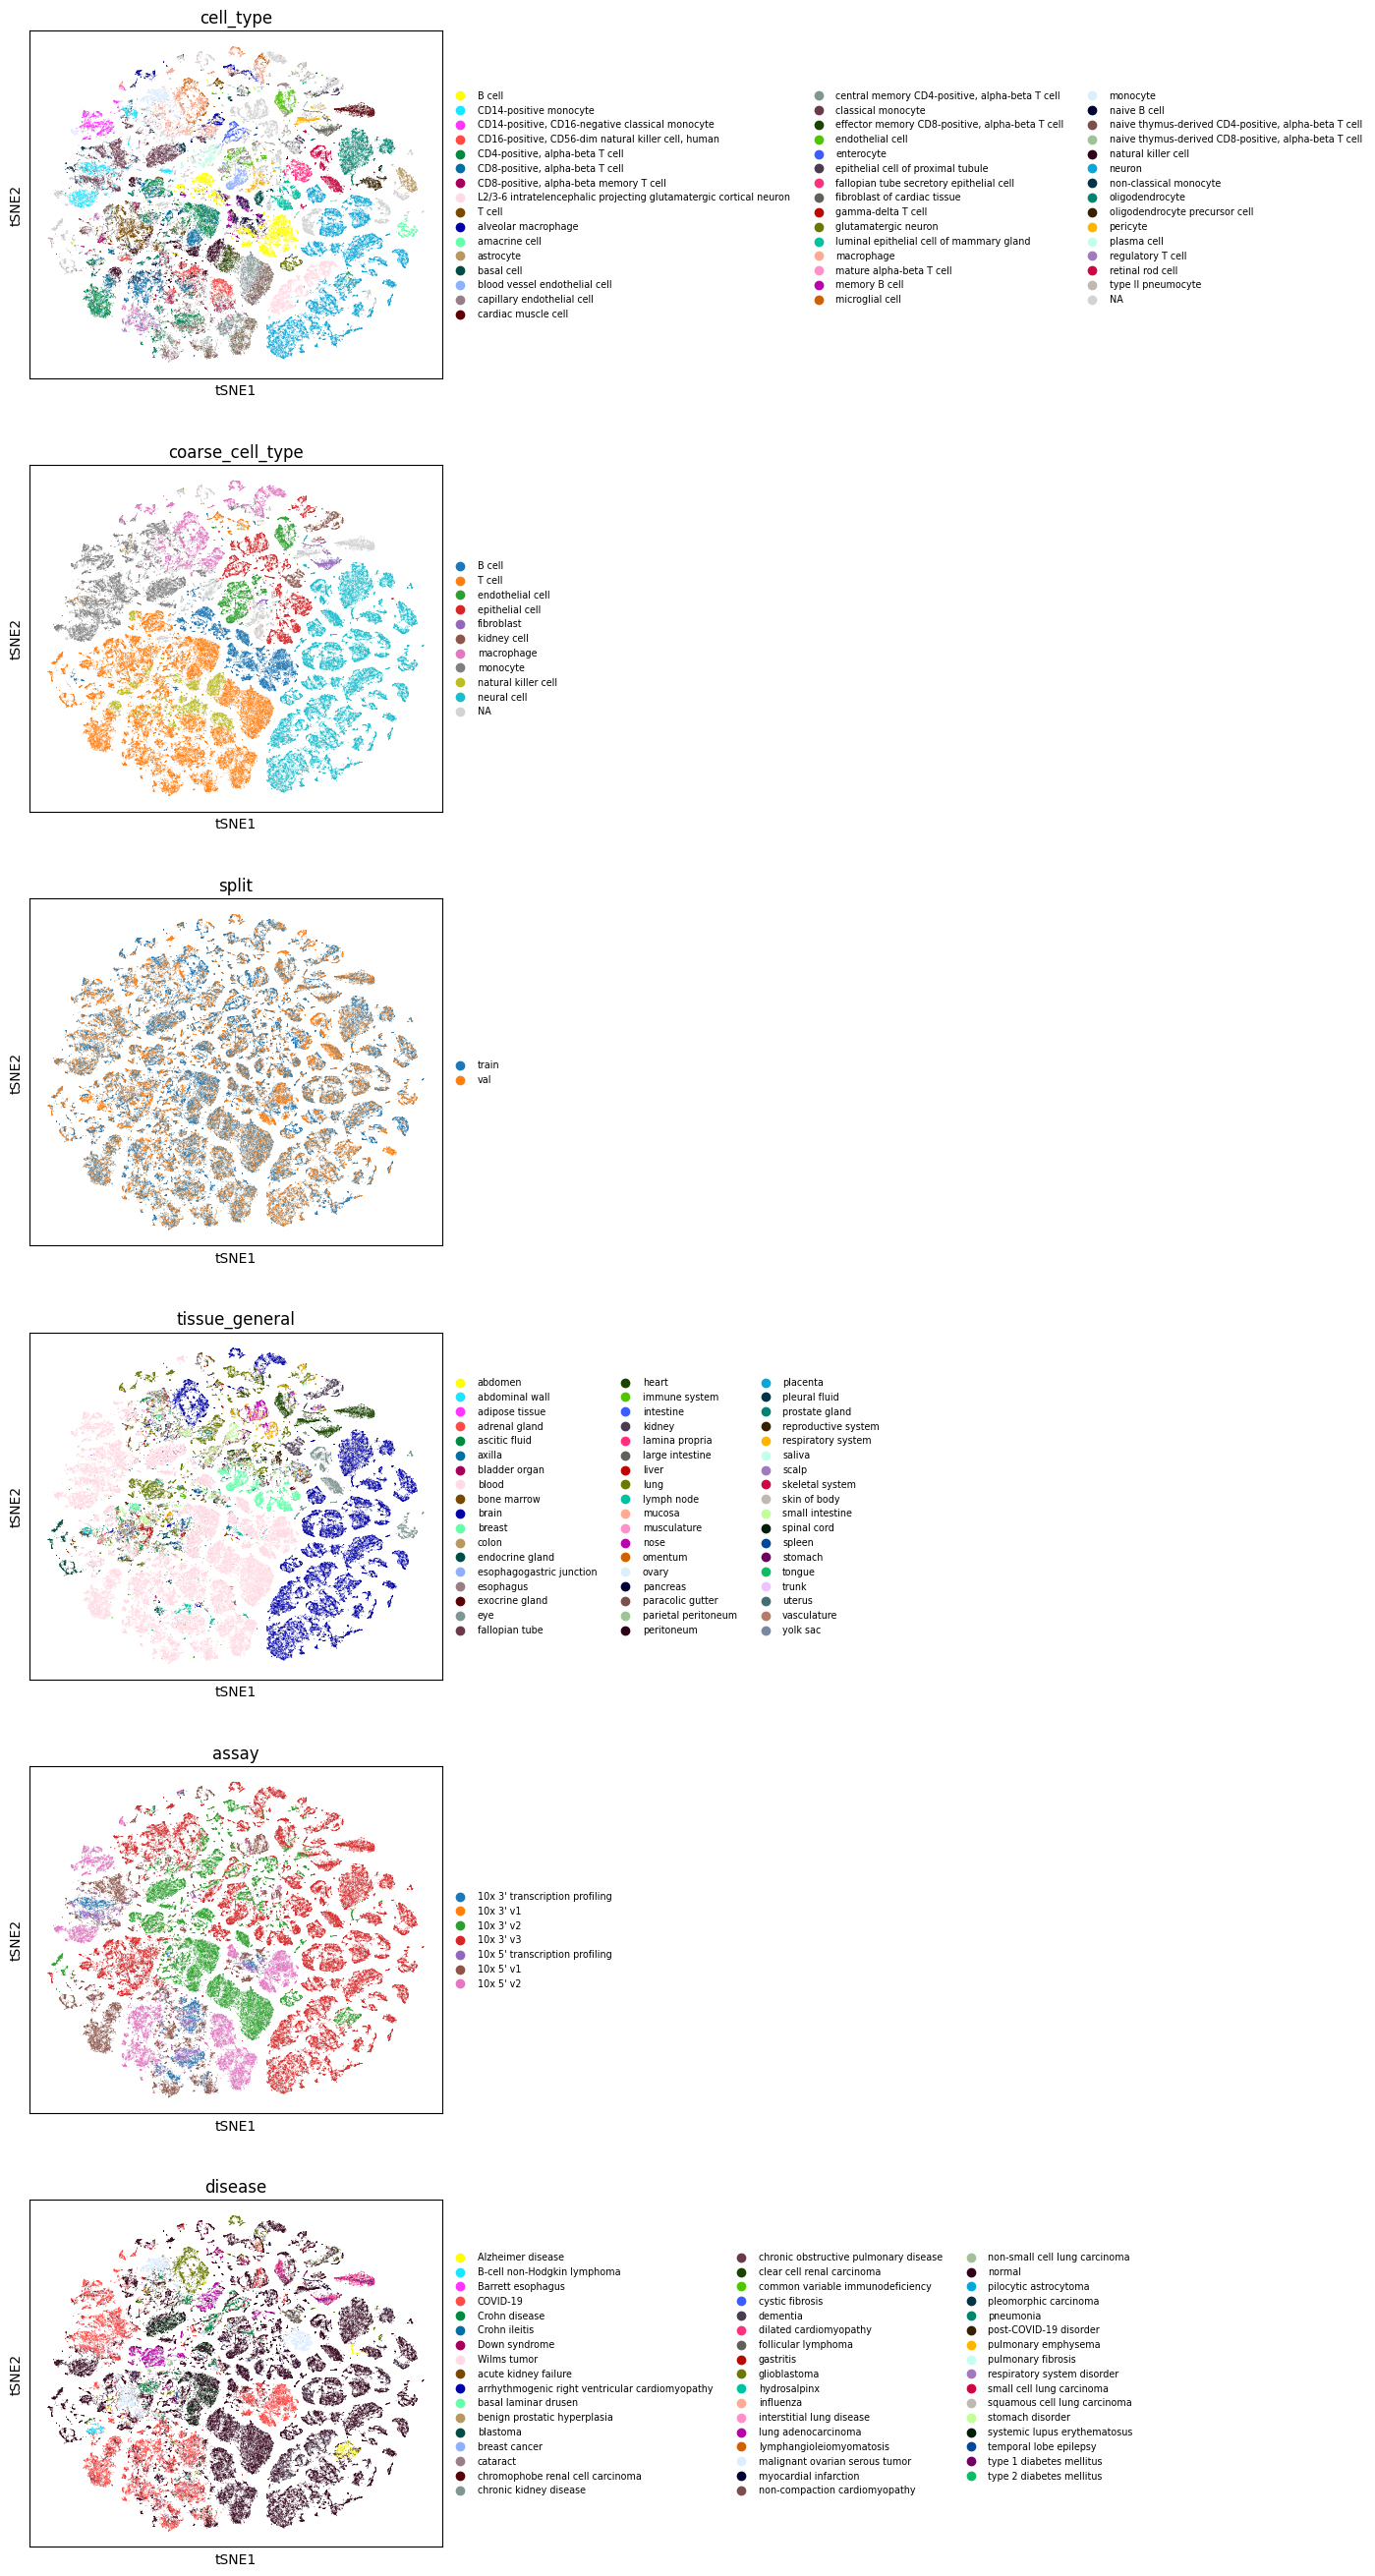

In [24]:
cell_freq = adata.obs.cell_type.value_counts()
cells_to_plot = cell_freq[cell_freq > 1000].index.tolist()
adata_plot = adata.copy()
adata_plot.obs['cell_type'] = adata_plot.obs.cell_type.mask(~adata_plot.obs.cell_type.isin(cells_to_plot))
adata_plot.obs['cell_type'] = adata_plot.obs['cell_type'].cat.remove_unused_categories()
sc.pl.tsne(
    adata_plot, 
    color=['cell_type', 'coarse_cell_type', 'split', 'tissue_general', 'assay', 'disease'], 
    legend_fontsize='x-small', 
    ncols=1
)

## Data statistics

In [13]:
x_train, obs_train = get_count_matrix_and_obs(ddf_train)
x_val, obs_val = get_count_matrix_and_obs(ddf_val)
x_test, obs_test = get_count_matrix_and_obs(ddf_test)


print('Train samples:', len(x_train))
print('Val samples:', len(x_val))
print('Test samples:', len(x_test))

Train samples: 15240192
Val samples: 3500032
Test samples: 3448832


In [22]:
obs = pd.concat([obs_train, obs_val, obs_test])

In [14]:
15240192 + 3500032 + 3448832

22189056

In [16]:
obs_train.tech_sample.nunique() + obs_val.tech_sample.nunique() + obs_test.tech_sample.nunique()

5052

In [19]:
len(tissue_general_mapping)

56

In [18]:
len(tissue_mapping)

197